In [ ]:
!pip install sentence-transformers -q
!pip install datasets -q

     |████████████████████████████████| 79 kB 3.1 MB/s 
     |████████████████████████████████| 4.2 MB 43.4 MB/s 
     |████████████████████████████████| 1.2 MB 47.4 MB/s 
     |████████████████████████████████| 86 kB 1.9 MB/s 
     |████████████████████████████████| 596 kB 52.1 MB/s 
     |████████████████████████████████| 6.6 MB 47.4 MB/s 
     |████████████████████████████████| 346 kB 5.2 MB/s 
     |████████████████████████████████| 1.1 MB 55.8 MB/s 
     |████████████████████████████████| 140 kB 65.3 MB/s 
     |████████████████████████████████| 212 kB 66.6 MB/s 
     |████████████████████████████████| 86 kB 6.7 MB/s 
     |████████████████████████████████| 127 kB 69.2 MB/s 
     |████████████████████████████████| 144 kB 70.2 MB/s 
     |████████████████████████████████| 94 kB 3.8 MB/s 
     |████████████████████████████████| 271 kB 72.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of 

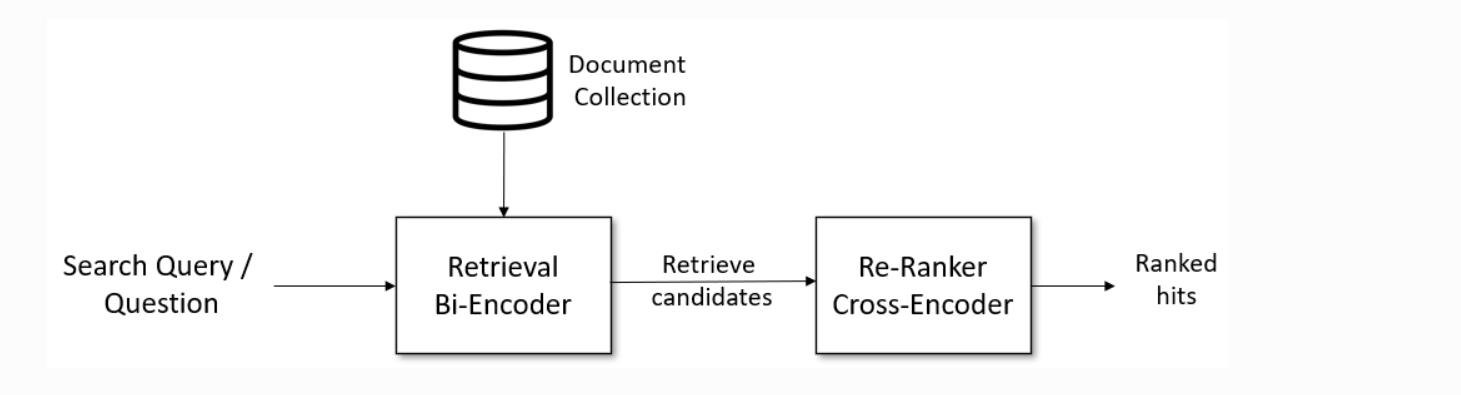

Retrieve(bi-encoder) & Re-Rank(cross-encoder)

In [ ]:
"""
This script contains an example how to perform re-ranking with a Cross-Encoder for semantic search.


Then, we re-rank the hits from the Bi-Encoder using a Cross-Encoder.
"""
from sentence_transformers import SentenceTransformer, util
from sentence_transformers import CrossEncoder
import os
import csv
import pickle
import time
import sys
import torch 

1 - Bi-Encoder pre-trained on stbenchmark-french using Camembert-large (state-of-the-art of sentence embeddings frrench)

In [ ]:
# We use a BiEncoder (SentenceTransformer) that produces embeddings for questions.
# We then search for similar questions using cosine similarity and identify the top X most similar questions

bi_encoder = torch.load('/content/drive/MyDrive/BiEncoder_AugCamembert_similarityV2.pth') # Pre-trained sentence embedding model created in previous colab
num_candidates = 10

2 - Cross-encoder model trained on stsbenchmark-french (created in encoder_Camembert)

In [ ]:
# To refine the results, we use a CrossEncoder. A CrossEncoder gets both inputs (input_question, retrieved_question)
# and outputs a score 0...1 indicating the similarity.
cross_encoder = torch.load("/content/drive/MyDrive/cross_encoder_camembert_similarity.pth")

In contrast, for a Cross-Encoder, we pass both sentences simultaneously to the Transformer network. It produces than an output value between 0 and 1 indicating the similarity of the input sentence pair:

A Cross-Encoder does not produce a sentence embedding. Also, we are not able to pass individual sentences to a Cross-Encoder.

As detailed in our paper, Cross-Encoder achieve better performances than Bi-Encoders. However, for many application they are not pratical as they do not produce embeddings we could e.g. index or efficiently compare using cosine similarity.

///////////// Example with the model created

In [ ]:
import numpy as np
corpus = ["Un avion est en train de décoller.",
          "Un homme joue d'une grande flûte.",
          "Un homme étale du fromage râpé sur une pizza.",
          "Une personne jette un chat au plafond.",
          "Une personne est en train de plier un morceau de papier.",
          ]
query = 'Mehdi plie un morceau de papier '

# So we create the respective sentence combinations
sentence_combinations = [[query, corpus_sentence] for corpus_sentence in corpus]

# Compute the similarity scores for these combinations
similarity_scores = cross_encoder.predict(sentence_combinations)

# Sort the scores in decreasing order
sim_scores_argsort = reversed(np.argsort(similarity_scores))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
# Print the scores
print("Query:", query)
for idx in sim_scores_argsort:
    print("{:.2f}\t{}".format(similarity_scores[idx], corpus[idx]))

Query: Mehdi plie un morceau de papier 
0.65	Une personne est en train de plier un morceau de papier.
0.01	Un homme étale du fromage râpé sur une pizza.
0.01	Un avion est en train de décoller.
0.01	Un homme joue d'une grande flûte.
0.01	Une personne jette un chat au plafond.


In [ ]:
##### Dataset we want to use
import pandas as pd

faq = pd.read_excel("/content/drive/MyDrive/FAQ-CMR.xlsx")
faq.head()


,Question,Réponse,Catégorie
0,"Je suis un fonctionnaire, comment m’affilier a...",Vous n'avez aucune démarche à faire pour cette...,Affiliation
1,J’étais un agent dans une collectivité territo...,"Oui, toutefois, vous devez informer votre Adm...",Affiliation
2,La date de naissance portée sur mon attestatio...,"En cas de discordance, merci de contacter votr...",Affiliation
3,Quelles sont les conditions nécessaires pour l...,Tous les affiliés aux régimes de base de gérés...,Attakmili
4,Quel est la cotisation minimale au titre du Ré...,La cotisation minimale est de 50 DHS,Attakmili


In [ ]:
faq[faq['Question']=="La date de naissance portée sur mon attestation d’affiliation n’est pas conforme à celle sur ma Carte d’Identité Nationale, comment la rectifier ?"]["Réponse"].tolist()[0]

'En cas de discordance, merci de contacter votre Administration afin de nous communiquer, une copie de l’extrait de votre acte de naissance que contient votre dossier de recrutement.'

In [ ]:
# Some local file to cache computed embeddings
max_corpus_size = 1000
embedding_cache_path = 'faq-embeddings-biEncoder-{}-size-{}.pkl'.format('camembert/camembert-large'.replace('/', '_'), max_corpus_size)

In [ ]:
# Get all unique sentences from the columns

corpus_sentences = set() # to remove duplicate questions

for row in range(faq.shape[0]):
  corpus_sentences.add(faq['Question'][row])
  if len(corpus_sentences) >= max_corpus_size:
    break

corpus_sentences = list(corpus_sentences)

##### Encode with Bi-encoder
print("Encode the corpus. This might take a while (in the case of a large dataset) ")
corpus_embeddings = bi_encoder.encode(corpus_sentences, show_progress_bar=True, convert_to_tensor=True)

print("Store file on disc")
with open(embedding_cache_path, "wb") as fOut:
  pickle.dump({'sentences': corpus_sentences, 'embeddings': corpus_embeddings}, fOut)

Encode the corpus. This might take a while (in the case of a large dataset) 


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Store file on disc


In [ ]:
###############################
print("Corpus loaded with {} sentences / embeddings".format(len(corpus_sentences)))

print(corpus_embeddings)

Corpus loaded with 77 sentences / embeddings
tensor([[ 0.2127, -0.1737, -0.0493,  ...,  0.1104, -0.0683, -0.0168],
        [ 0.1994, -0.3647,  0.3202,  ...,  0.1539, -0.1471,  0.2985],
        [ 0.1976, -0.6210,  0.4474,  ..., -0.0809,  0.2060,  0.4467],
        ...,
        [-0.0768, -0.2928,  0.2750,  ..., -0.2288,  0.0855, -0.0375],
        [-0.1056,  0.1162,  0.0753,  ...,  0.2459,  0.3861,  0.2488],
        [-0.0242,  0.2303,  0.0793,  ...,  0.1567, -0.2262, -0.2511]],
       device='cuda:0')


In [ ]:
while True:
    inp_question = input("Please enter a question: ")
    if inp_question == 'No question':
      break
    else:
      print("Input question:", inp_question)

      #First, retrieve candidates using cosine similarity search
      
      start_time = time.time()
      question_embedding = bi_encoder.encode(inp_question, convert_to_tensor=True)
      # we use util.semantic_search to perform cosine similarty + topk
      hits = util.semantic_search(question_embedding, corpus_embeddings, top_k=num_candidates)
      hits = hits[0]  #Get the hits for the first query (cosinus_similarity)

      print("Cosine-Similarity search took {:.3f} seconds".format(time.time()-start_time))
      print("Top 5 hits with cosine-similarity:")
      for hit in hits[0:5]:
          print("\t{:.3f}\t{}".format(hit['score'], corpus_sentences[hit['corpus_id']]))


      #Now, do the re-ranking with the cross-encoder
      start_time = time.time()
      sentence_pairs = [[inp_question, corpus_sentences[hit['corpus_id']]] for hit in hits]
      ce_scores = cross_encoder.predict(sentence_pairs)

      for idx in range(len(hits)):
          hits[idx]['cross-encoder_score'] = ce_scores[idx]

      #Sort list by CrossEncoder scores
      hits = sorted(hits, key=lambda x: x['cross-encoder_score'], reverse=True)
      print("\nRe-ranking with Cross-Encoder took {:.3f} seconds".format(time.time() - start_time))
      print("Top 5 hits with CrossEncoder:")
      for hit in hits[0:5]:
          print("\t{:.3f}\t{}".format(hit['cross-encoder_score'], corpus_sentences[hit['corpus_id']]))

      print("\n\n========\n")

Please enter a question: j'ai un nouveau bébé, comment je fais l'inscription ?
Input question: j'ai un nouveau bébé, comment je fais l'inscription ?
Cosine-Similarity search took 0.028 seconds
Top 5 hits with cosine-similarity:
	0.671	Comment faut-il procéder pour inscrire de nouvelles naissances ?
	0.597	ِComment faut-il procéder pour inscrire des enfants handicapés ?
	0.423	La date de naissance portée sur mon attestation d’affiliation n’est pas conforme à celle sur ma Carte d’Identité Nationale, comment la rectifier ?
	0.413	Comment faut-il procéder pour demander la radiation d’un enfant décédé ?
	0.411	Dois-je effectuer une démarche spécifique pour mon adhésion à la mutuelle ?

Re-ranking with Cross-Encoder took 0.152 seconds
Top 5 hits with CrossEncoder:
	0.758	Comment faut-il procéder pour inscrire de nouvelles naissances ?
	0.252	ِComment faut-il procéder pour inscrire des enfants handicapés ?
	0.169	Dois-je effectuer une démarche spécifique pour mon adhésion à la mutuelle ?
	0.1

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


In [ ]:
from re import A
while True:
    inp_question = input("Please enter a question: ")
    if inp_question == 'no':
      break
    else:
      print("Input question:", inp_question)

      #First, retrieve candidates using cosine similarity search
      
      start_time = time.time()
      question_embedding = bi_encoder.encode(inp_question, convert_to_tensor=True)
      # we use util.semantic_search to perform cosine similarty + topk
      hits = util.semantic_search(question_embedding, corpus_embeddings, top_k=num_candidates)
      hits = hits[0]  #Get the hits for the first query (cosinus_similarity)

      print("Cosine-Similarity search took {:.3f} seconds".format(time.time()-start_time))
      print("Top 5 hits with cosine-similarity:")
      
      data={
          "similarity": list(),
          "Question": list(),
          "Reponse" : list()
      }

      for hit in hits[0:5]:
        a = corpus_sentences[hit['corpus_id']]
        if len(faq[faq['Question']==a]["Réponse"].tolist()) > 1:
          for res in faq[faq['Question']==a]["Réponse"].tolist():
            data['Question'] = data['Question'] + [corpus_sentences[hit['corpus_id']]]
            data['Reponse'] = data['Reponse'] + [res]
            data['similarity'] = data['similarity']+ [hit['score']]
        else :
          data['Question'] = data['Question'] + [corpus_sentences[hit['corpus_id']]]
          data['Reponse'] = data['Reponse'] + faq[faq['Question']==a]["Réponse"].tolist()
          data['similarity'] = data['similarity']+ [hit['score']]
        
        
      #print(len(data['Question']), len(data['Reponse']), len(data['similarity'])) 
      df =  pd.DataFrame(data).sort_values("similarity", ascending=False)
      display(df)
      
        

         # print("\t{:.3f}\t{}".format(hit['score'], corpus_sentences[hit['corpus_id']]))


      #Now, do the re-ranking with the cross-encoder
      start_time = time.time()
      sentence_pairs = [[inp_question, corpus_sentences[hit['corpus_id']]] for hit in hits]
      ce_scores = cross_encoder.predict(sentence_pairs)

      for idx in range(len(hits)):
          hits[idx]['cross-encoder_score'] = ce_scores[idx]

      #Sort list by CrossEncoder scores
      hits = sorted(hits, key=lambda x: x['cross-encoder_score'], reverse=True)
      print("\nRe-ranking with Cross-Encoder took {:.3f} seconds".format(time.time() - start_time))
      print("Top 5 hits with CrossEncoder:")

      data={
          "similarity": list(),
          "Question": list(),
          "Reponse" : list()
      }

      for hit in hits[0:5]:
        a = corpus_sentences[hit['corpus_id']]
        if len(faq[faq['Question']==a]["Réponse"].tolist()) > 1:
          for res in faq[faq['Question']==a]["Réponse"].tolist():
            data['Question'] = data['Question'] + [corpus_sentences[hit['corpus_id']]]
            data['Reponse'] = data['Reponse'] + [res]
            data['similarity'] = data['similarity']+ [hit['cross-encoder_score']]
        else :
          data['Question'] = data['Question'] + [corpus_sentences[hit['corpus_id']]]
          data['Reponse'] = data['Reponse'] + faq[faq['Question']==a]["Réponse"].tolist()
          data['similarity'] = data['similarity']+ [hit['cross-encoder_score']]

      df =  pd.DataFrame(data).sort_values("similarity", ascending=False)
      display(df)


        
          #print("\t{:.3f}\t{}".format(hit['cross-encoder_score'], corpus_sentences[hit['corpus_id']]))

      print("\n\n========\n")
      

Please enter a question: comment faire l'inscription des handicapés ?
Input question: comment faire l'inscription des handicapés ?
Cosine-Similarity search took 0.025 seconds
Top 5 hits with cosine-similarity:


,similarity,Question,Reponse
0,0.835615,ِComment faut-il procéder pour inscrire des enfants handicapés ?,"Afin d’inscrire des enfants handicapés, un pensionne militaire doit fournir à la CMR les éléments suivants : Certificat médical précisant la nature de la maladie, sa date de survenue et l’aptitude ou non au travail certifié par le conseil de santé provincial ;\nContre visite médicale délivrée par le conseil de santé provincial ;\nExtrait d’acte de naissance de l’enfant ;\nCertificat de vie ;\nCopie légalisée de la CNI de l’enfant ;\nCertificat de non mariage ;\nAttestation de non emploi"
1,0.621930,Quelle est la démarche à suivre pour bénéficier d'une pension d'invalidité ?,"Le dossier d’invalidité doit être constitué par l’administration et soumis à une commission de réforme qui se charge de l’appréciation de la réalité des infirmités, leur imputabilité au service ainsi que le taux d’invalidité."
2,0.548559,"Je suis orphelin(e) handicapé(e), je voudrai bénéficier de la réversion de la pension d’invalidité. Quelles sont les pièces que je dois fournir à la CMR ?","Extrait d’acte de naissance (+ CNI pour les orphelins majeurs); Certificats de célibat\nAttestation de non emploi \nCertificat médical délivré par un médecin spécialiste précisant la nature de l’handicap, sa date d’apparition et l’aptitude ou non au travail\nContre visite médicale délivrée par le conseil de santé provincial \nExtrait d’acte de naissance de la mère de l’orphelin handicapé si elle est divorcée et non citée dans l’acte d’hérédité\nCopie légalisée de l’acte de tutelle délivré par le tribunal de 1ère instance dans le cas où l’orphelin handicapé est mineur et sa mère est décédée\nCopie légalisée de l’acte de curatelle délivré du tribunal de 1ère instance dans le cas où l’orphelin est atteint d’un handicap mental, est majeur et sa mère est décédée."
3,0.544036,Quelles sont les pièces à fournir à la CMR pour bénéficier de la réversion de la pension d’invalidité au profit de l’enfant handicapé?,"Acte de naissance de l’enfant handicapé ;\nCopie de la CNI\nAttestation de non mariage\nAttestation de non travail,\nCertificat médical délivré par un médecin spécialiste précisant la nature de l’handicap, sa date d’apparition et l’aptitude ou non au travail,\nContre visite médicale délivrée par le conseil de santé provincial précisant la nature de l’handicap, sa date d’apparition et l’aptitude ou non au travail,\nExtrait d’acte de naissance de la mère de l’orphelin handicapé si elle est divorcée et non citée dans l’acte d’hérédité\nCopie légalisée de l’acte de tutelle délivré du tribunal de 1ère instance dans le cas où l’orphelin handicapé est mineur et sa mère est décédée,\nCopie légalisée de l’acte de curatelle délivré du tribunal de 1ère instance dans le cas où l’orphelin est atteint d’un handicap mental, est majeur et sa mère est décédée."
4,0.523071,Quelles sont les pièces à fournir à la CMR pour bénéficier de la réversion des allocations forfaitaires à l’orphelin handicapé?,"Extrait d’acte de naissance de l’orphelin ;\nCopie de la CNI ;\nAttestation de non mariage ;\nCertificat médical délivré par un médecin spécialiste précisant la nature de l’handicap, sa date d’apparition et l’aptitude ou non au travail ;\nContre visite médicale délivrée par le conseil de santé provincial précisant la nature de l’handicap, sa date d’apparition et l’aptitude ou non au travail ;\nAttestation de revenus délivrée par les autorités locales précisant la nature et montants annuels des revenus de l’orphelin handicapé depuis la date du décès du Résistant ;\nCertificat d’impôt modèle 4169 précisant la nature et montants annuels des revenus de l’orphelin handicapé depuis la date du décès du Résistant ;\nExtrait d’acte de naissance de la mère de l’orphelin handicapé si elle est divorcée,\n• Copie légalisée de l’acte de tutelle délivré du tribunal de 1ère instance dans le cas où l’orphelin handicapé est mineur et sa mère est décédée ;\nCopie légalisée de l’acte de curatelle délivré du


Re-ranking with Cross-Encoder took 0.075 seconds
Top 5 hits with CrossEncoder:


,similarity,Question,Reponse
0,0.809186,ِComment faut-il procéder pour inscrire des enfants handicapés ?,"Afin d’inscrire des enfants handicapés, un pensionne militaire doit fournir à la CMR les éléments suivants : Certificat médical précisant la nature de la maladie, sa date de survenue et l’aptitude ou non au travail certifié par le conseil de santé provincial ;\nContre visite médicale délivrée par le conseil de santé provincial ;\nExtrait d’acte de naissance de l’enfant ;\nCertificat de vie ;\nCopie légalisée de la CNI de l’enfant ;\nCertificat de non mariage ;\nAttestation de non emploi"
1,0.243775,Quelle est la démarche à suivre pour bénéficier d'une pension d'invalidité ?,"Le dossier d’invalidité doit être constitué par l’administration et soumis à une commission de réforme qui se charge de l’appréciation de la réalité des infirmités, leur imputabilité au service ainsi que le taux d’invalidité."
2,0.193784,Je suis orphelin(e) handicapé(e je voudrai bénéficier de la réversion de la pension de retraite. Quelles sont les pièces que je dois fournir à la CMR ?,"Extrait d’acte de naissance (+ CNI pour les orphelins majeurs); Certificats de célibat\nAttestation de non travail \nCertificat médical délivré par un médecin spécialiste précisant la nature de l’handicap, sa date d’apparition et l’aptitude ou non au travail\nContre visite médical délivré par le conseil de santé provincial précisant la nature de l’handicap, sa date d’apparition et l’aptitude ou non au travail\nExtrait d’acte de naissance de la mère de l’orphelin handicapé si elle est divorcée et non citée dans l’acte d’hérédité\nCopie légalisée de l’acte de tutelle délivré par le tribunal de 1ère instance dans le cas où l’orphelin handicapé est mineur et sa mère est décédée."
3,0.191309,Comment faut-il procéder pour inscrire de nouvelles naissances ?,"Pour inscrire de nouvelles naissances, un pensionne militaire doit fournir à la CMR les éléments suivants : Extrait d’acte de naissance ;\nCertificat de vie ;\nCertificats de scolarité pour les enfants ayant l’âge entre 16 ans et 21 ans."
4,0.191309,Comment faut-il procéder pour inscrire de nouvelles naissances ?,Vous devez présenter une demande jointe des pièces nécessaires à la CMR.Les pièces constituant un dossier de demande des allocations familiales : (Pièces)\n\nNouvelle naissance\nEnfant infirme
5,0.189421,Que dois-je faire pour continuer à percevoir les allocations des enfants infirmes ?,Chaque année la CMR vous contactera pour vous demander un Certificat de Célibat et un certificat de Non-emploi de l’enfant infirme. Un dossier médical actualisé peut également vous être demandé.





Please enter a question: j'ai un nouveau bébé, comment je fais l'inscription ?
Input question: j'ai un nouveau bébé, comment je fais l'inscription ?
Cosine-Similarity search took 0.024 seconds
Top 5 hits with cosine-similarity:


,similarity,Question,Reponse
0,0.683232,Comment faut-il procéder pour inscrire de nouvelles naissances ?,"Pour inscrire de nouvelles naissances, un pensionne militaire doit fournir à la CMR les éléments suivants : Extrait d’acte de naissance ;\nCertificat de vie ;\nCertificats de scolarité pour les enfants ayant l’âge entre 16 ans et 21 ans."
1,0.683232,Comment faut-il procéder pour inscrire de nouvelles naissances ?,Vous devez présenter une demande jointe des pièces nécessaires à la CMR.Les pièces constituant un dossier de demande des allocations familiales : (Pièces)\n\nNouvelle naissance\nEnfant infirme
2,0.589089,ِComment faut-il procéder pour inscrire des enfants handicapés ?,"Afin d’inscrire des enfants handicapés, un pensionne militaire doit fournir à la CMR les éléments suivants : Certificat médical précisant la nature de la maladie, sa date de survenue et l’aptitude ou non au travail certifié par le conseil de santé provincial ;\nContre visite médicale délivrée par le conseil de santé provincial ;\nExtrait d’acte de naissance de l’enfant ;\nCertificat de vie ;\nCopie légalisée de la CNI de l’enfant ;\nCertificat de non mariage ;\nAttestation de non emploi"
3,0.472113,Quelle démarche dois-je effectuer suite à une promotion de grade ou un avancement d’échelon régularisé après ma radiation des cadres ?,"Vous n’avez aucune démarche à effectuer. Votre pension sera révisée, instantanément dès réception de l’information de régularisation de votre situation administrative des services de la Trésorerie Générale du Royaume (échange de données informatisées)."
4,0.456638,Comment faut-il procéder pour demander la radiation d’un enfant décédé ?,Vous devez communiquer à la CMR un acte de décès de votre enfant joint éventuellement d’une copie de sa CNIE.
5,0.431736,Quelle est la démarche à suivre pour bénéficier d'une pension d'invalidité ?,"Le dossier d’invalidité doit être constitué par l’administration et soumis à une commission de réforme qui se charge de l’appréciation de la réalité des infirmités, leur imputabilité au service ainsi que le taux d’invalidité."



Re-ranking with Cross-Encoder took 0.076 seconds
Top 5 hits with CrossEncoder:


,similarity,Question,Reponse
0,0.758273,Comment faut-il procéder pour inscrire de nouvelles naissances ?,"Pour inscrire de nouvelles naissances, un pensionne militaire doit fournir à la CMR les éléments suivants : Extrait d’acte de naissance ;\nCertificat de vie ;\nCertificats de scolarité pour les enfants ayant l’âge entre 16 ans et 21 ans."
1,0.758273,Comment faut-il procéder pour inscrire de nouvelles naissances ?,Vous devez présenter une demande jointe des pièces nécessaires à la CMR.Les pièces constituant un dossier de demande des allocations familiales : (Pièces)\n\nNouvelle naissance\nEnfant infirme
2,0.251719,ِComment faut-il procéder pour inscrire des enfants handicapés ?,"Afin d’inscrire des enfants handicapés, un pensionne militaire doit fournir à la CMR les éléments suivants : Certificat médical précisant la nature de la maladie, sa date de survenue et l’aptitude ou non au travail certifié par le conseil de santé provincial ;\nContre visite médicale délivrée par le conseil de santé provincial ;\nExtrait d’acte de naissance de l’enfant ;\nCertificat de vie ;\nCopie légalisée de la CNI de l’enfant ;\nCertificat de non mariage ;\nAttestation de non emploi"
3,0.169217,Dois-je effectuer une démarche spécifique pour mon adhésion à la mutuelle ?,"Votre adhésion continue sans démarche (une continuité automatique des précomptes dès la mise en paiement de votre pension). Vous devez, en revanche, aviser votre organisme mutualiste de votre mise à la retraite pour une mise à jour."
4,0.161014,Comment faut-il procéder pour changer mon nom ?,"Pour changer son nom, un pensionné militaire doit fournir à la CMR les éléments suivants : Demande de changement de nom ;\nCopie légalisée du décret de changement de nom ou acte de jugement du tribunal ;\nCopie légalisée de la CNI\nExtrait d’acte de naissance ;\nCopie de la carte de pensionné.\nLe brevet d’inscription."
5,0.127324,"La date de naissance portée sur mon attestation d’affiliation n’est pas conforme à celle sur ma Carte d’Identité Nationale, comment la rectifier ?","En cas de discordance, merci de contacter votre Administration afin de nous communiquer, une copie de l’extrait de votre acte de naissance que contient votre dossier de recrutement."





Please enter a question: no
